In [231]:
#Importo mis librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV

In [ ]:
#Importo mis datos y creo mis df
datos_gen=pd.read_excel(r"C:\Users\omarl\Downloads\data_final.xlsx")
datos_fem=pd.read_excel(r"C:\Users\omarl\Downloads\datos_combinados_femeninos (2).xlsx")
datos_masc=pd.read_excel(r"C:\Users\omarl\Downloads\Python\datos_combinados.xlsx")

In [3]:
#Elimino la columna de Ign
datos_masc.drop('Ign', axis=1, inplace=True)
datos_fem.drop('Ign', axis=1, inplace=True)
datos_gen.drop('Ign', axis=1, inplace=True)

In [4]:
#Normalizo la columna de padecimientos de los datos
datos_fem['Padecimiento'] = datos_fem['Padecimiento'].str.strip()  
datos_fem['Padecimiento'] = datos_fem['Padecimiento'].str.replace(r'\s+', ' ', regex=True) 
datos_fem['Padecimiento'] = datos_fem['Padecimiento'].str.lower() 

datos_masc['Padecimiento'] = datos_masc['Padecimiento'].str.strip()  
datos_masc['Padecimiento'] = datos_masc['Padecimiento'].str.replace(r'\s+', ' ', regex=True) 
datos_masc['Padecimiento'] = datos_masc['Padecimiento'].str.lower() 

datos_gen['Padecimiento'] = datos_gen['Padecimiento'].str.strip()  
datos_gen['Padecimiento'] = datos_gen['Padecimiento'].str.replace(r'\s+', ' ', regex=True) 
datos_gen['Padecimiento'] = datos_gen['Padecimiento'].str.lower() 

In [ ]:
#Cambio el tipo de dato a string
datos_gen['Padecimiento'] = datos_gen['Padecimiento'].astype(str)
datos_fem['Padecimiento'] = datos_fem['Padecimiento'].astype(str)
datos_masc['Padecimiento'] = datos_masc['Padecimiento'].astype(str)

In [6]:
# Agregar etiquetas a cada DataFrame
datos_gen['Tipo'] = 'General'
datos_masc['Tipo'] = 'Masculino'
datos_fem['Tipo'] = 'Femenino'

# Concatenar sin ordenar por año
datos_unificados = pd.concat([datos_gen, datos_masc, datos_fem], ignore_index=True)

datos_unificados.head()

,Numero,Padecimiento,>1,1 - 4,5 - 9,10 - 14,15 - 19,20 - 24,25 - 44,45 - 49,50 - 59,60 - 64,65+,Total,Año,Tipo
0,1,infecciones respiratorias agudas,3634900,6966455,4223184,2536979,1543296,1619513,5137461,980299,1218285,518796,925216,29318354,2000,General
1,2,infecciones intestinales por otros organismos,620611,1002640,442202,325862,256892,371900,1252765,227408,296180,125322,259806,5184776,2000,General
2,3,infección de vías urinarias,32019,137907,144777,112105,180932,326620,1136103,222968,289478,121583,250162,2956492,2000,General
3,4,amebiasis intestinal,79354,261502,200409,149244,94707,93112,265967,56601,65032,28911,52938,1348718,2000,General
4,5,"úlceras, gastritis y duodenitis",219,804,17808,47336,102825,150621,506851,115353,146416,64374,126092,1280268,2000,General


In [7]:
# Eliminar filas que corresponden a "otras causas" si no son relevantes para el Top 20
# Asumimos que 'Numero' == 21 corresponde a "otras causas"
datos_unificados = datos_unificados[datos_unificados['Numero'] <= 20]

In [8]:
datos_unificados.isnull().sum()

Numero          0
Padecimiento    0
>1              0
 1 - 4          0
 5 - 9          0
 10 - 14        0
 15 - 19        0
 20 - 24        0
 25 - 44        0
 45 - 49        0
 50 - 59        0
 60 - 64        0
65+             0
Total           0
Año             0
Tipo            0
dtype: int64

In [9]:
# Limpieza de nombres de columnas
datos_unificados.columns = datos_unificados.columns.str.strip().str.replace(' ', '').str.lower()

# Verificación de los nuevos nombres de las columnas
datos_unificados.columns

Index(['numero', 'padecimiento', '>1', '1-4', '5-9', '10-14', '15-19', '20-24',
       '25-44', '45-49', '50-59', '60-64', '65+', 'total', 'año', 'tipo'],
      dtype='object')

In [10]:
columnas_rangos=['>1', '1-4', '5-9', '10-14', '15-19', '20-24',
       '25-44', '45-49', '50-59', '60-64', '65+']

In [93]:
# Codificación de variables categóricas
# Convertir 'Tipo' y 'Padecimiento' a variables numéricas
label_encoder_pad = LabelEncoder()
label_encoder_tip = LabelEncoder()
datos_unificados['padecimiento_enc'] = label_encoder_pad.fit_transform(datos_unificados['padecimiento'])
datos_unificados['tipo_enc'] = label_encoder_tip.fit_transform(datos_unificados['tipo'])

In [445]:
# Seleccionar las columnas de características (X) y la variable objetivo (y)
# Incluiremos 'Año', 'Tipo_enc', 'Padecimiento_enc', y las distribuciones por rangos de edad
X = datos_unificados[['año', 'tipo_enc', 'padecimiento_enc']]
y = datos_unificados[['total'] + columnas_rangos]

In [446]:
# Escalar las características y la variable objetivo
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

y_log = np.log1p(y)

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y_log)

In [447]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, 
                                                    test_size=0.2,random_state=42)

In [468]:
# Construcción del modelo de red neuronal con Keras
model = keras.models.Sequential()
model.add(keras.layers.Dense(256,activation='leaky_relu',input_dim=X_train.shape[1]))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(128,activation='leaky_relu'))
model.add(keras.layers.Dense(128, activation='leaky_relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(y_train.shape[1], activation='relu'))  # Salida para regresión múltiple

In [469]:
#Defino el callback de early stopping para que pare su entrenamiento antes de sobreajustarse
# Callbacks para mejorar el entrenamiento
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, min_lr=1e-6)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True)

In [470]:
# Compilación del modelo
#opt=keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [471]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=1000, 
                    batch_size=64,
                    verbose=1,
                    callbacks=[early_stop,reduce_lr])

Epoch 1/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2304 - mae: 0.4209 - val_loss: 0.0573 - val_mae: 0.1845 - learning_rate: 0.0010
Epoch 2/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0757 - mae: 0.2211 - val_loss: 0.0488 - val_mae: 0.1699 - learning_rate: 0.0010
Epoch 3/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0623 - mae: 0.1973 - val_loss: 0.0433 - val_mae: 0.1600 - learning_rate: 0.0010
Epoch 4/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0508 - mae: 0.1782 - val_loss: 0.0384 - val_mae: 0.1458 - learning_rate: 0.0010
Epoch 5/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0482 - mae: 0.1695 - val_loss: 0.0361 - val_mae: 0.1413 - learning_rate: 0.0010
Epoch 6/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0431 - mae: 0.1596 - val_loss: 0.0347 - val_mae: 0.1373 - learning_rate: 0.0010
Epoch 7/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0418 - mae: 0.1559 - val_loss: 0.0350 - val_mae: 0.1416 - learning_rate: 0.0010
Epoch 

In [472]:
# Evaluación del modelo
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Pérdida (MSE): {loss}')
print(f'Error Absoluto Medio (MAE): {mae}')

Pérdida (MSE): 0.0064782435074448586
Error Absoluto Medio (MAE): 0.0529523603618145


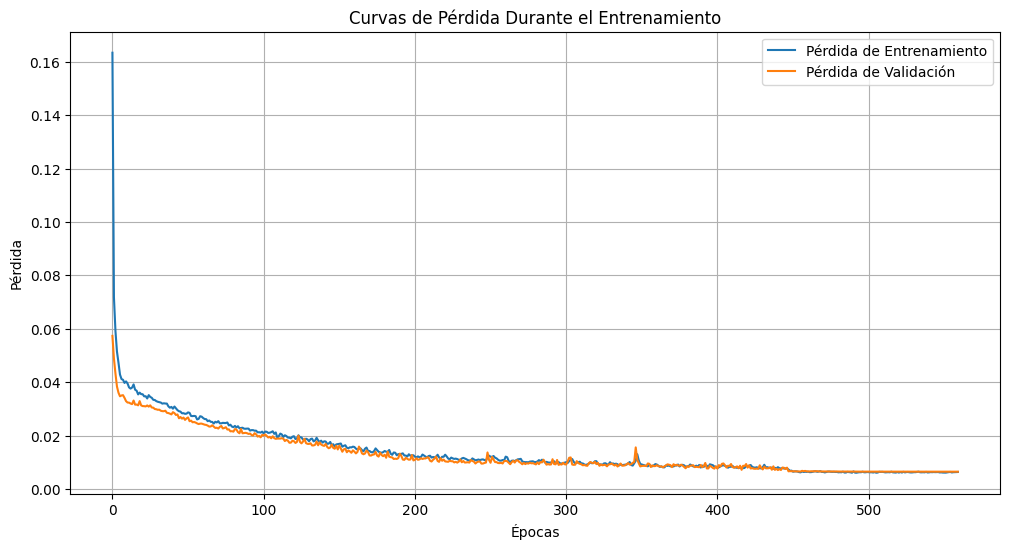

In [473]:
# Visualizar las curvas de aprendizaje
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Curvas de Pérdida Durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

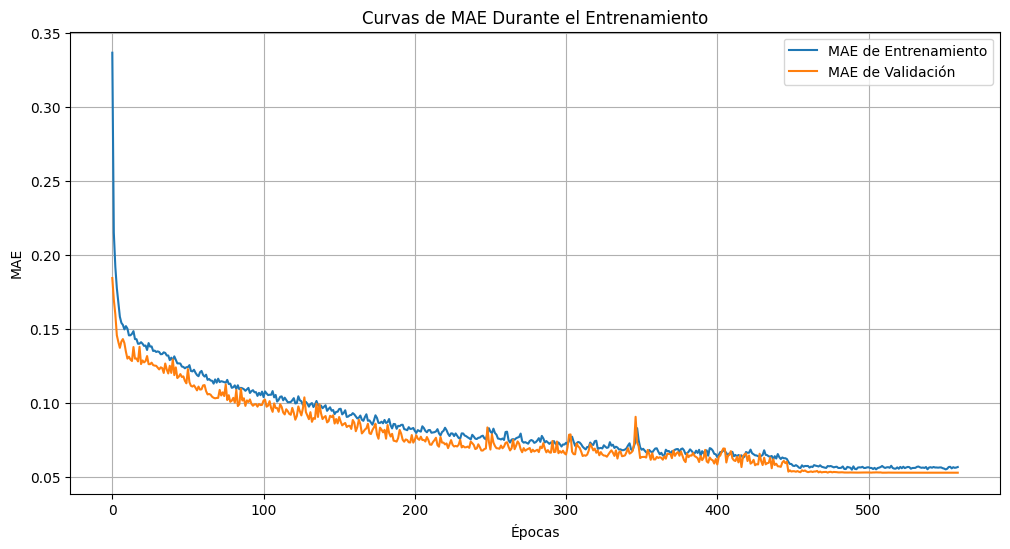

In [474]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('Curvas de MAE Durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [475]:
# Crear un DataFrame para los años futuros (2024-2026) y las categorías
años_futuros = [2024, 2025, 2026]
categorias = ['General', 'Masculino', 'Femenino']

# Identificar las enfermedades únicas en los datos históricos
enfermedades_unicas = datos_unificados['padecimiento'].unique()

In [476]:
# Crear un DataFrame vacío para almacenar las predicciones
predicciones_futuras = []

In [477]:
# Iterar por cada categoría
for tipo in categorias:
    # Filtrar enfermedades para la categoría actual
    enfermedades_tipo = datos_unificados[datos_unificados['tipo'] == tipo]['padecimiento'].unique()
    
    # Iterar por cada enfermedad en la categoría
    for año in años_futuros:
        # Crear registros para los años futuros
        for enfermedad in enfermedades_tipo:
            predicciones_futuras.append({
                'año': año,
                'tipo': tipo,
                'padecimiento': enfermedad
            })


# Crear el DataFrame con las predicciones futuras
predicciones_futuras = pd.DataFrame(predicciones_futuras)

In [478]:
predicciones_futuras.head()

,año,tipo,padecimiento
0,2024,General,infecciones respiratorias agudas
1,2024,General,infecciones intestinales por otros organismos
2,2024,General,infección de vías urinarias
3,2024,General,amebiasis intestinal
4,2024,General,"úlceras, gastritis y duodenitis"


In [479]:
# Codificar las columnas 'Padecimiento' y 'Tipo' usando el mismo LabelEncoder
predicciones_futuras['padecimiento_enc'] = label_encoder_pad.transform(predicciones_futuras['padecimiento'])
predicciones_futuras['tipo_enc'] = label_encoder_tip.transform(predicciones_futuras['tipo'])

In [ ]:
# Seleccionar las columnas de características
X_futuro = predicciones_futuras[['año', 'tipo_enc', 'padecimiento_enc']]

In [481]:
# Escalar las características usando el mismo scaler que se usó para el entrenamiento
X_futuro_scaled = scaler_X.transform(X_futuro)

In [482]:
# Realizar las predicciones
predicciones = model.predict(X_futuro_scaled)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [483]:
# Invertir el escalado de las predicciones
predicciones_descaled = np.expm1(scaler_y.inverse_transform(predicciones))

In [484]:
# Verificar el rango de valores escalados para las predicciones
print("Valores escalados de predicciones:", predicciones.min(), predicciones.max())

# Verificar los valores escalados de las variables objetivo
print("Rango de valores de y_scaled:", y_scaled.min(), y_scaled.max())

print("Rango de valores de y:", y.min(), y.max())

# Verificar las predicciones desescaladas
print("Predicciones desescaladas:", predicciones_descaled.min(), predicciones_descaled.max())


Valores escalados de predicciones: 0.0 0.9634632
Rango de valores de y_scaled: 0.0 1.0
Rango de valores de y: total    40470
>1           0
1-4          0
5-9          0
10-14        0
15-19        0
20-24        0
25-44      633
45-49      191
50-59       65
60-64        0
65+          0
dtype: int64 total    31217059
>1        3634900
1-4       7299726
5-9       4855773
10-14     3259924
15-19     1985531
20-24     1686179
25-44     5314073
45-49     1499531
50-59     2109497
60-64     1003425
65+       1580599
dtype: int64
Predicciones desescaladas: 0.0 12236558.0


In [485]:
# Añadir las predicciones al DataFrame
predicciones_futuras[['Total_pred', '>1_pred', '1 - 4_pred', '5 - 9_pred', 
                      '10 - 14_pred', '15 - 19_pred', '20 - 24_pred', 
                      '25 - 44_pred', '45 - 49_pred', '50 - 59_pred', 
                      '60 - 64_pred', '65+_pred']] = predicciones_descaled

In [486]:
predicciones_futuras = predicciones_futuras[['año', 'tipo', 'padecimiento', 'Total_pred',
                                             '>1_pred', '1 - 4_pred', '5 - 9_pred', 
                                             '10 - 14_pred', '15 - 19_pred', '20 - 24_pred', 
                                             '25 - 44_pred', '45 - 49_pred', '50 - 59_pred', 
                                             '60 - 64_pred', '65+_pred']]

In [487]:
resultados=[]
# Agrupar las predicciones por año y categoría
for año in años_futuros:
    for tipo in categorias:
        # Filtrar las predicciones para el año y tipo actual
        subset = predicciones_futuras[(predicciones_futuras['año'] == año) & 
                                      (predicciones_futuras['tipo'] == tipo)]
        
        # Ordenar por Total_pred descendente para obtener el Top 20
        top20 = subset.sort_values(by='Total_pred', ascending=False).head(20)

        # Agregar una columna de ranking basada en el orden de 'Total_pred'
        top20['Número'] = range(1, len(top20) + 1)
        
        # Almacenar los resultados en la lista
        for index, row in top20.iterrows():
            resultados.append({
                'Número': row['Número'],
                'Año': año,
                'Tipo': tipo,
                'Padecimiento': row['padecimiento'],
                'Total_pred': row['Total_pred'],
                '>1_pred': row['>1_pred'],
                '1 - 4_pred': row['1 - 4_pred'],
                '5 - 9_pred': row['5 - 9_pred'],
                '10 - 14_pred': row['10 - 14_pred'],
                '15 - 19_pred': row['15 - 19_pred'],
                '20 - 24_pred': row['20 - 24_pred'],
                '25 - 44_pred': row['25 - 44_pred'],
                '45 - 49_pred': row['45 - 49_pred'],
                '50 - 59_pred': row['50 - 59_pred'],
                '60 - 64_pred': row['60 - 64_pred'],
                '65+_pred': row['65+_pred']
            })
        
        print(f"\nTop 20 Enfermedades para {tipo} en el año {año}:")
        print(top20[['padecimiento', 'Total_pred', '>1_pred', '1 - 4_pred', '5 - 9_pred', '10 - 14_pred', '15 - 19_pred', '20 - 24_pred', '25 - 44_pred', '45 - 49_pred', '50 - 59_pred', '60 - 64_pred', '65+_pred']].to_string(index=False))


Top 20 Enfermedades para General en el año 2024:
                                 padecimiento   Total_pred       >1_pred   1 - 4_pred   5 - 9_pred  10 - 14_pred  15 - 19_pred  20 - 24_pred  25 - 44_pred  45 - 49_pred  50 - 59_pred  60 - 64_pred      65+_pred
             infecciones respiratorias agudas 1.223656e+07 767858.500000 2.365491e+06 2.131909e+06  1.143180e+06 755256.375000 982423.812500  2.770991e+06 818636.375000  1.186042e+06 556726.250000 938288.562500
infecciones intestinales por otros organismos 5.599830e+06 129796.429688 3.673481e+05 3.301017e+05  2.144679e+05 262955.500000 369765.218750  1.205065e+06 365910.000000  5.262946e+05 243216.515625 412245.843750
                  infección de vías urinarias 2.700528e+06  29036.332031 1.079616e+05 1.244039e+05  1.066978e+05 128400.640625 194909.171875  6.813632e+05 222328.406250  3.294029e+05 152980.640625 260750.218750
              úlceras, gastritis y duodenitis 1.009611e+06    670.435242 3.420324e+03 1.357883e+04  3.4044

In [488]:
# Convertir la lista de resultados en un DataFrame
df_resultados = pd.DataFrame(resultados)

# Guardar el DataFrame en un archivo Excel
df_resultados.to_excel('predicciones_futuras_con_ranking.xlsx', index=False, engine='openpyxl')

print("Las predicciones con ranking se han guardado en el archivo 'predicciones_futuras_con_ranking.xlsx'")

Las predicciones con ranking se han guardado en el archivo 'predicciones_futuras_con_ranking.xlsx'


In [497]:
predicciones_futuras.to_excel('total_prediccionjes.xlsx',index=False, engine='openpyxl')

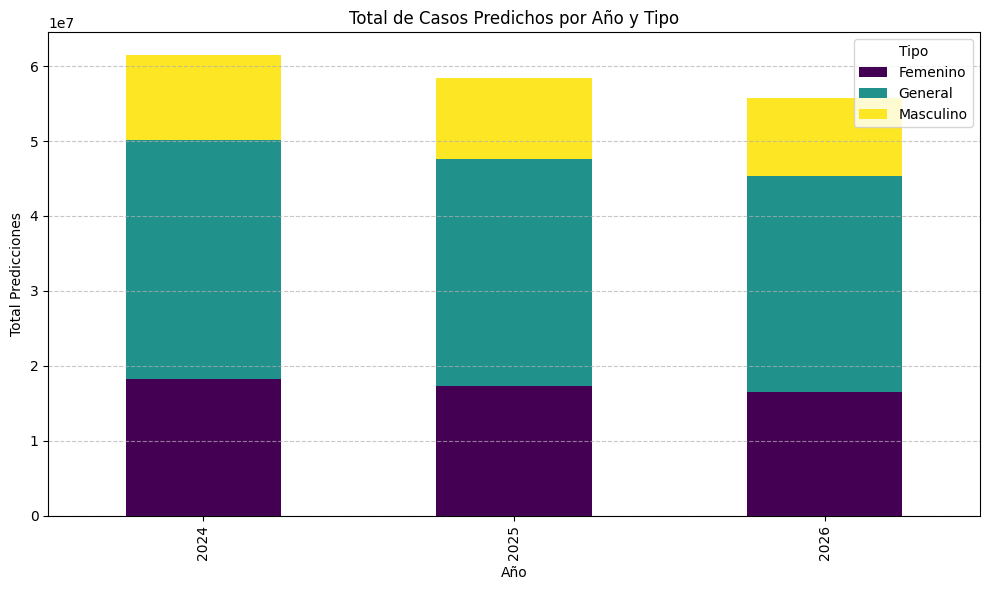

In [489]:
# Agrupación por año y tipo
totales_por_tipo = predicciones_futuras.groupby(['año', 'tipo'])['Total_pred'].sum().unstack()

# Gráfico de barras apiladas
totales_por_tipo.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Total de Casos Predichos por Año y Tipo')
plt.ylabel('Total Predicciones')
plt.xlabel('Año')
plt.legend(title='Tipo')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

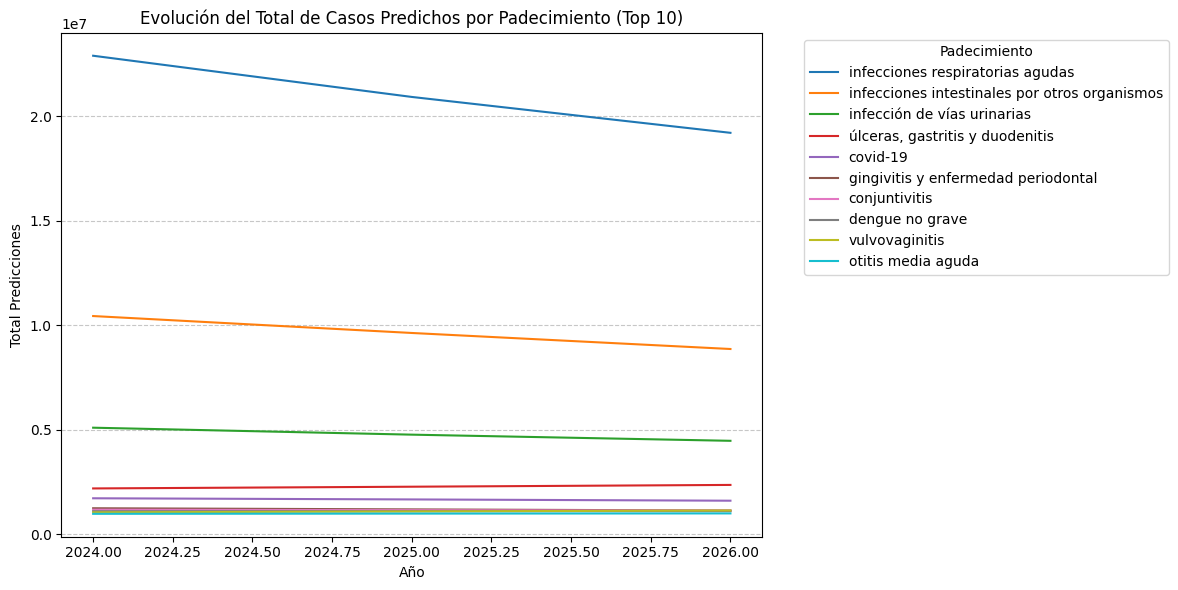

In [490]:
# Agrupar por año y padecimiento
evolucion_padecimientos = predicciones_futuras.groupby(['año', 'padecimiento'])['Total_pred'].sum().unstack()

# Filtrar solo los padecimientos más relevantes (por ejemplo, los más comunes en el primer año)
padecimientos_relevantes = evolucion_padecimientos.loc[2024].nlargest(10).index
evolucion_relevantes = evolucion_padecimientos[padecimientos_relevantes]

# Gráfico de líneas
evolucion_relevantes.plot(figsize=(12, 6))
plt.title('Evolución del Total de Casos Predichos por Padecimiento (Top 10)')
plt.ylabel('Total Predicciones')
plt.xlabel('Año')
plt.legend(title='Padecimiento', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

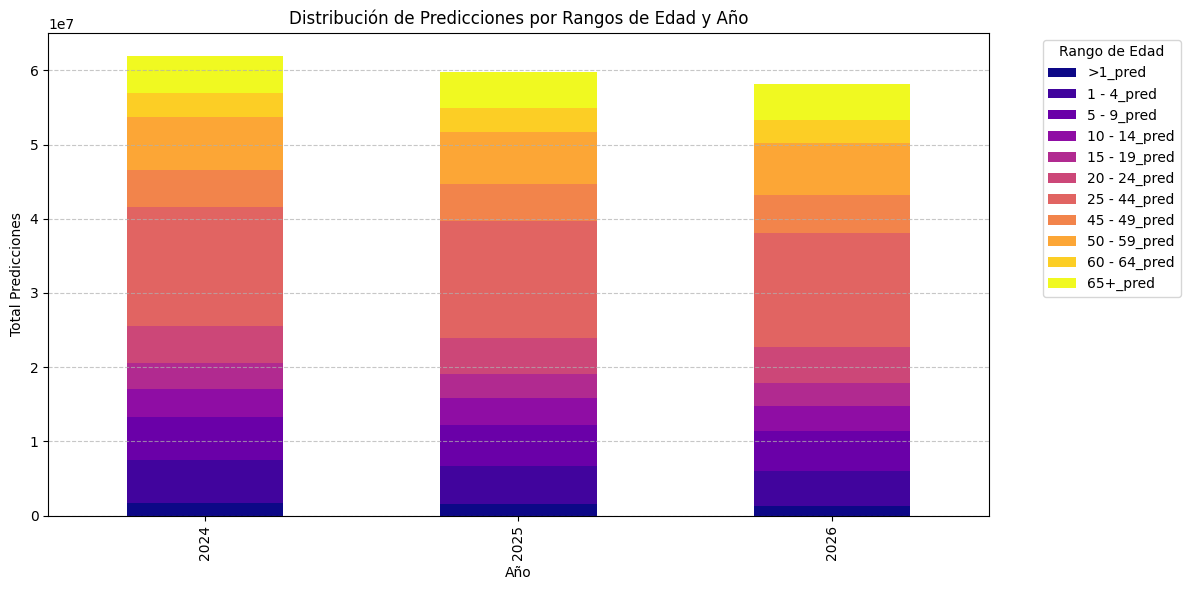

In [491]:
# Rangos de edades a graficar
columnas_rangos_pred = ['>1_pred', '1 - 4_pred', '5 - 9_pred', '10 - 14_pred', 
                        '15 - 19_pred', '20 - 24_pred', '25 - 44_pred', 
                        '45 - 49_pred', '50 - 59_pred', '60 - 64_pred', '65+_pred']

# Agrupar por año y sumar los rangos de edad
distribucion_edades = predicciones_futuras.groupby('año')[columnas_rangos_pred].sum()

# Gráfico de barras apiladas
distribucion_edades.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='plasma')
plt.title('Distribución de Predicciones por Rangos de Edad y Año')
plt.ylabel('Total Predicciones')
plt.xlabel('Año')
plt.legend(title='Rango de Edad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


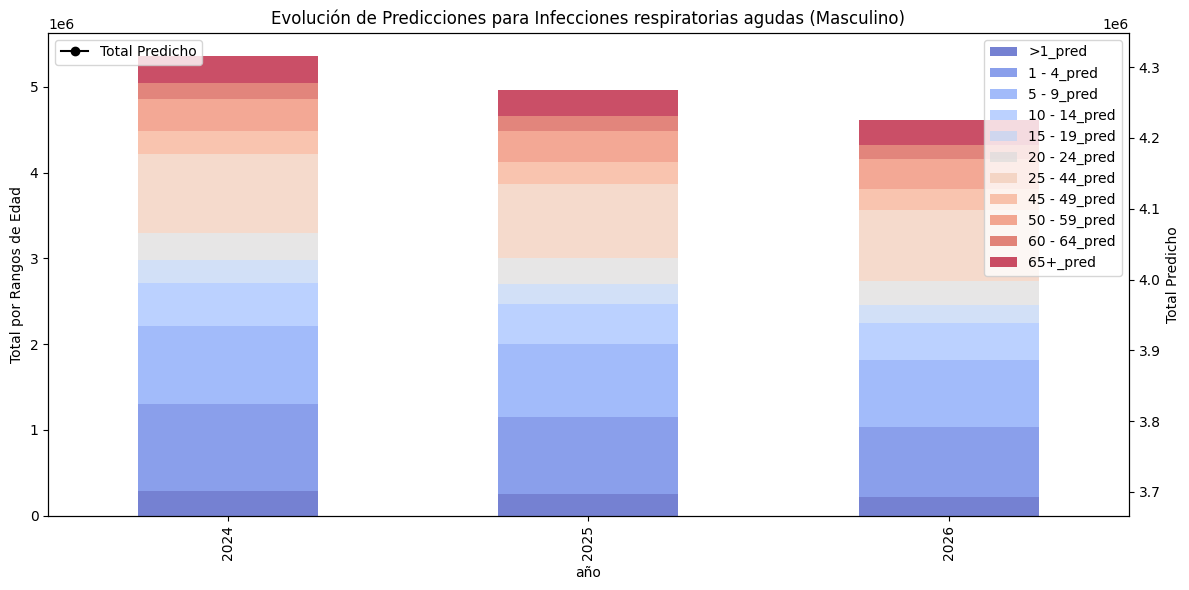

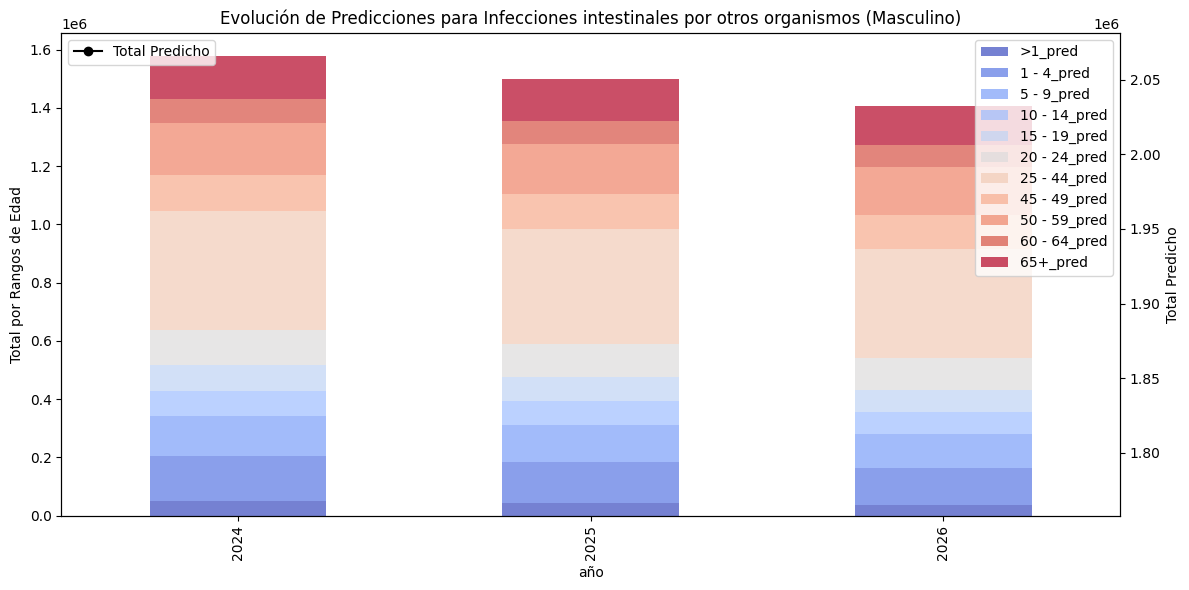

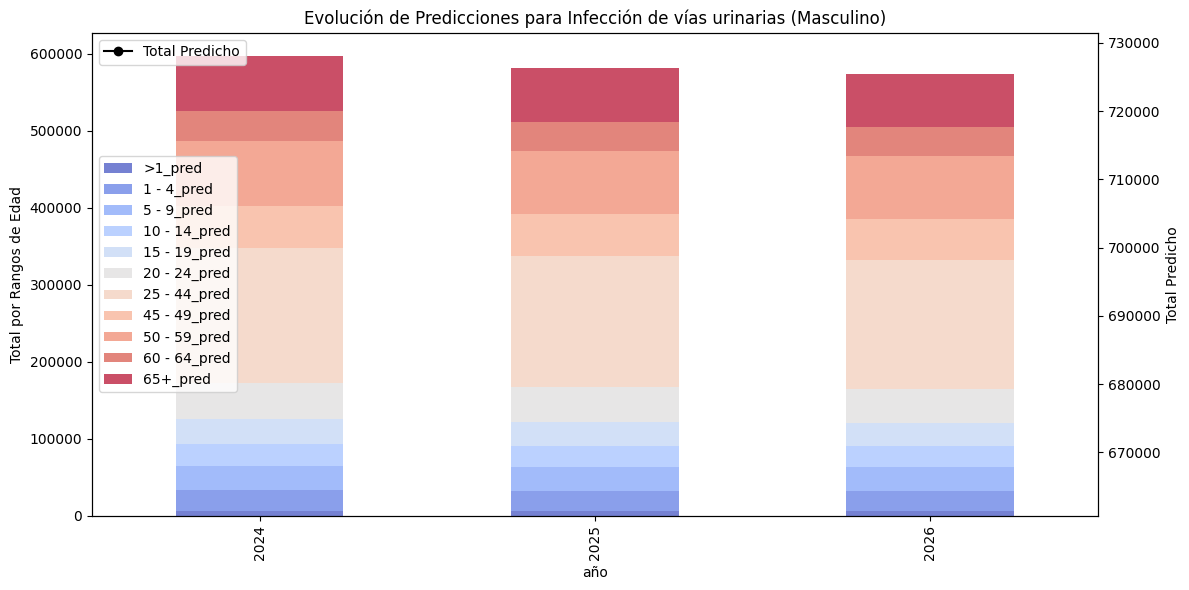

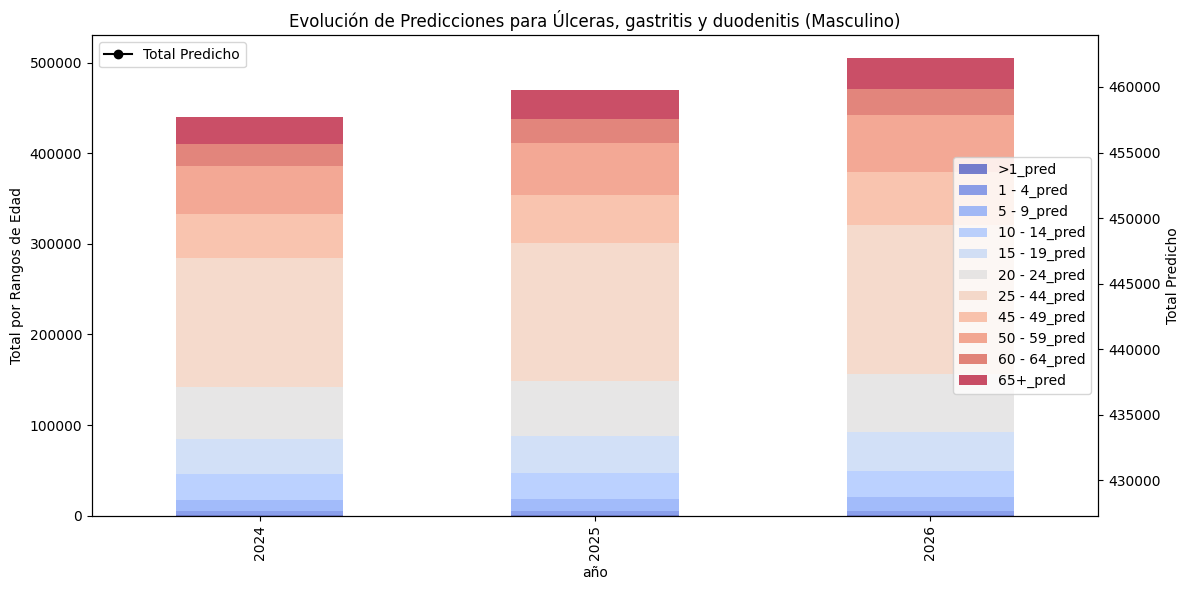

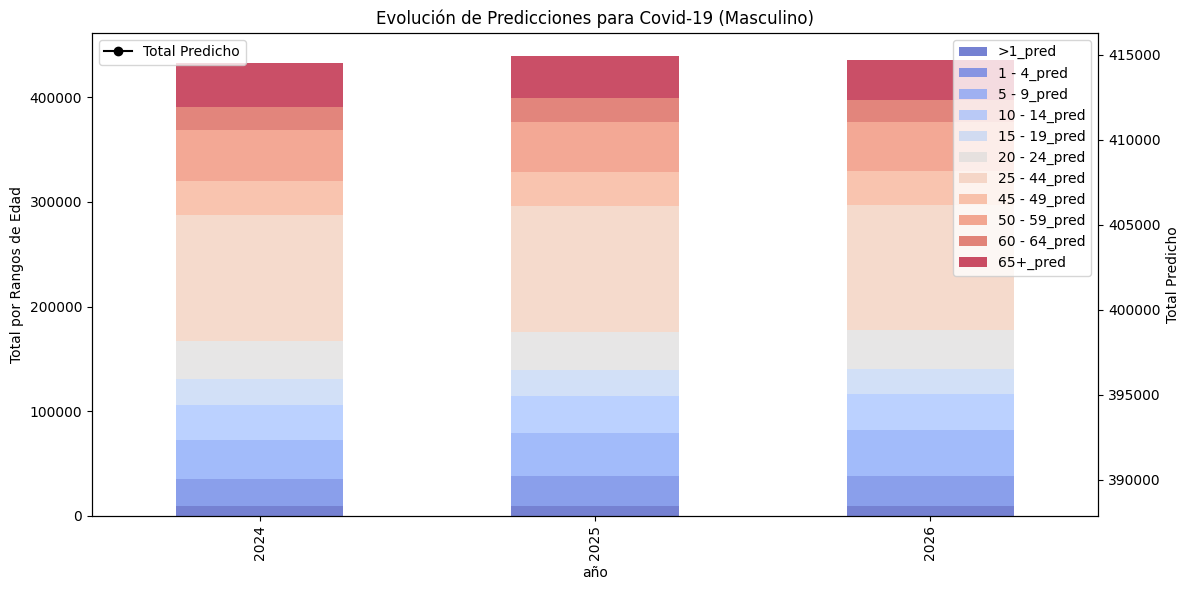

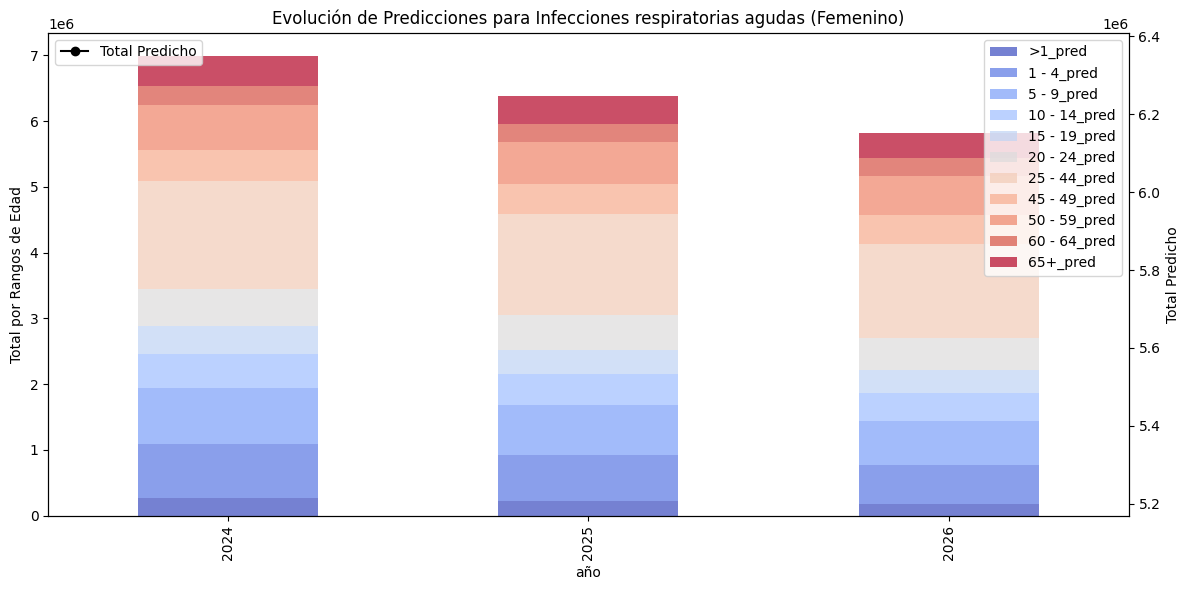

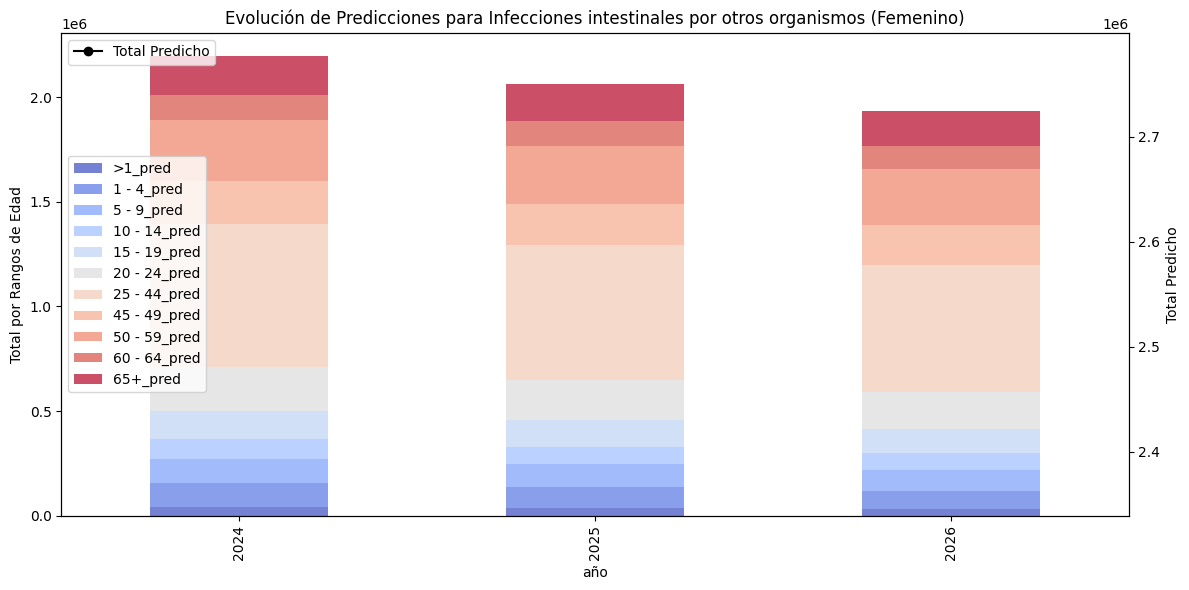

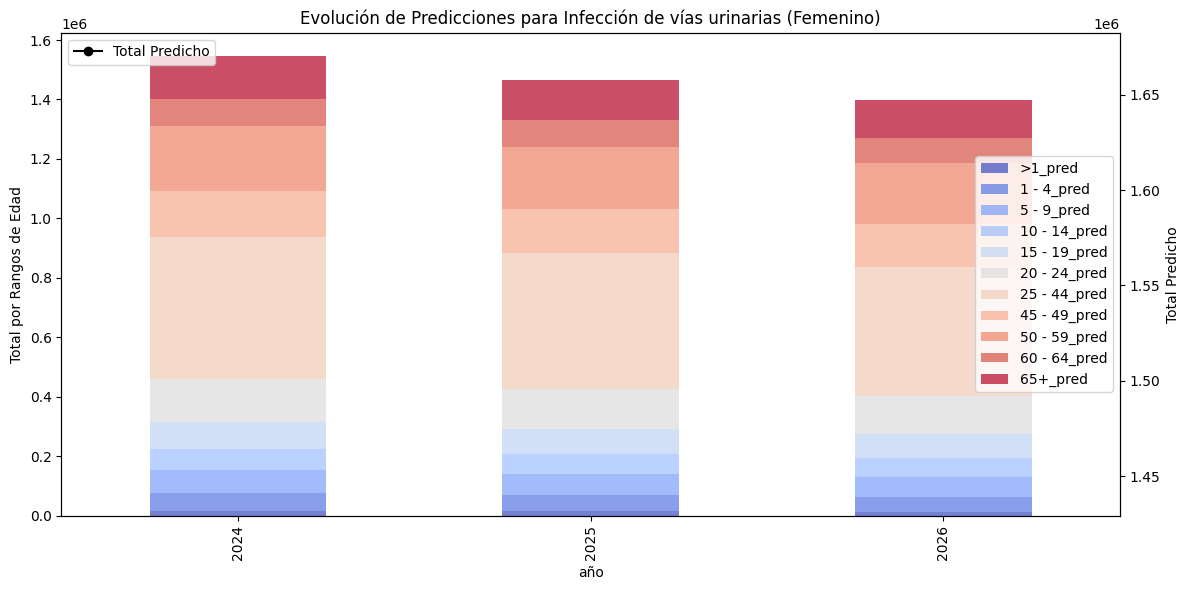

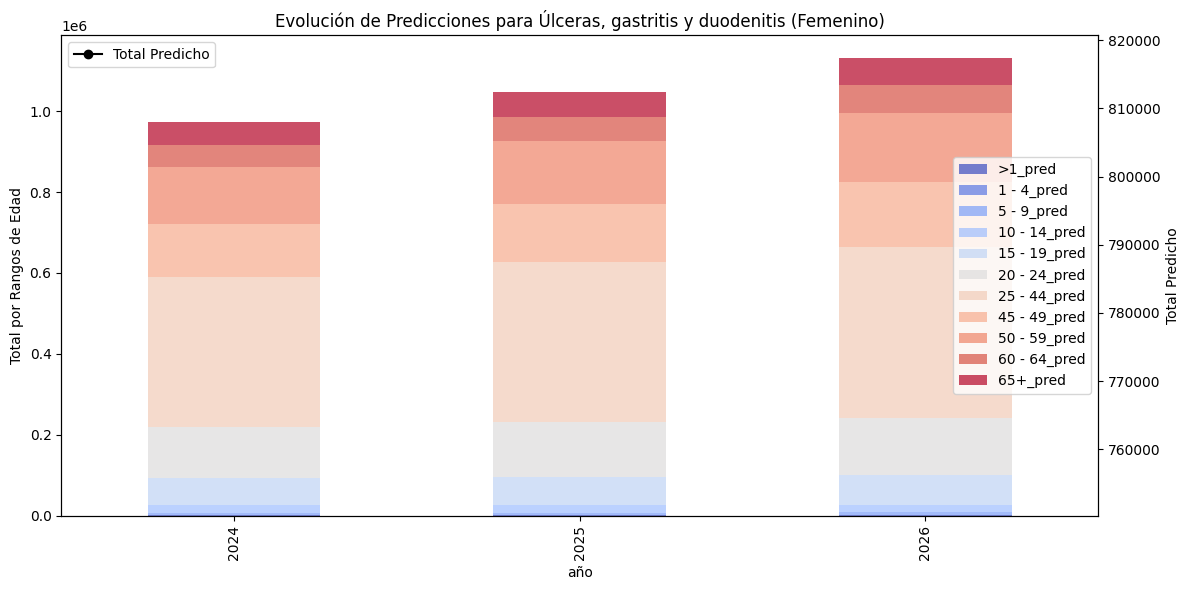

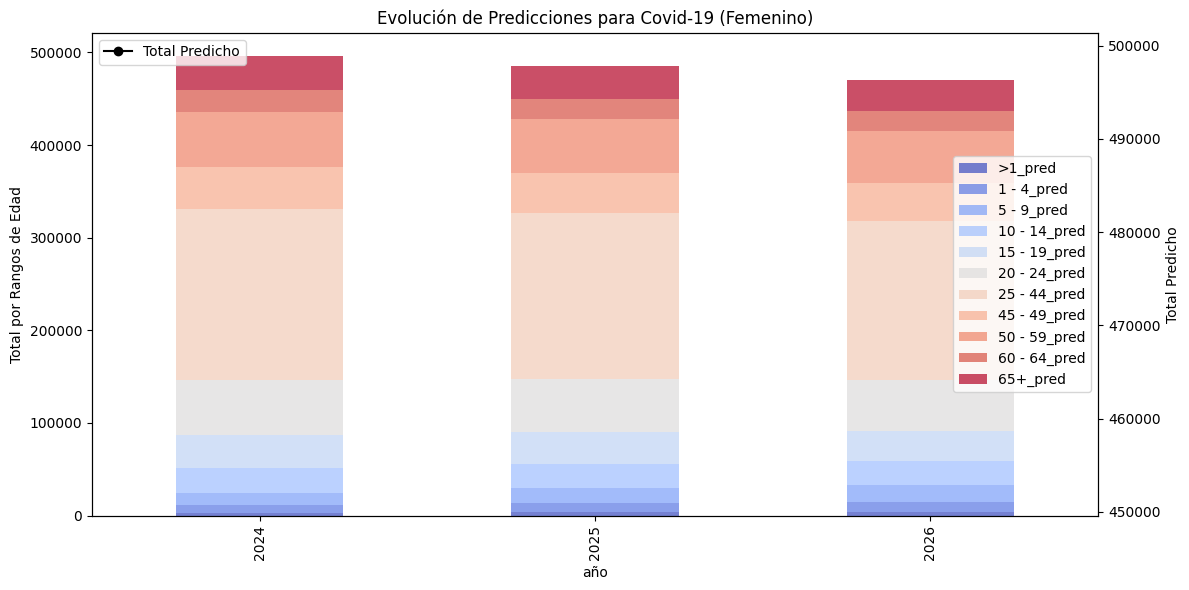

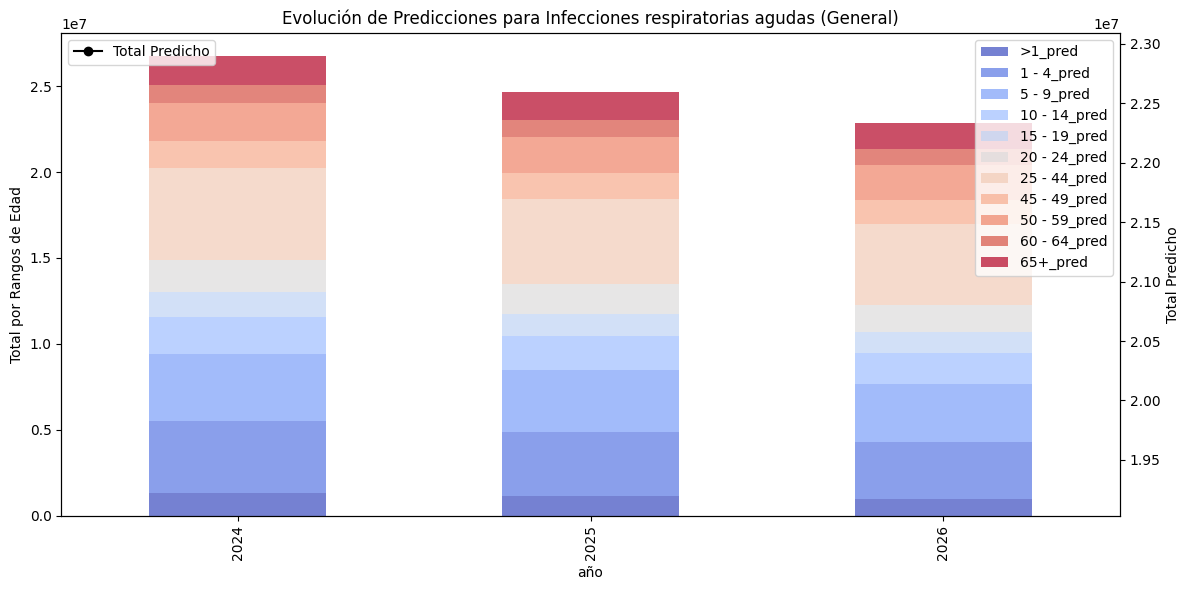

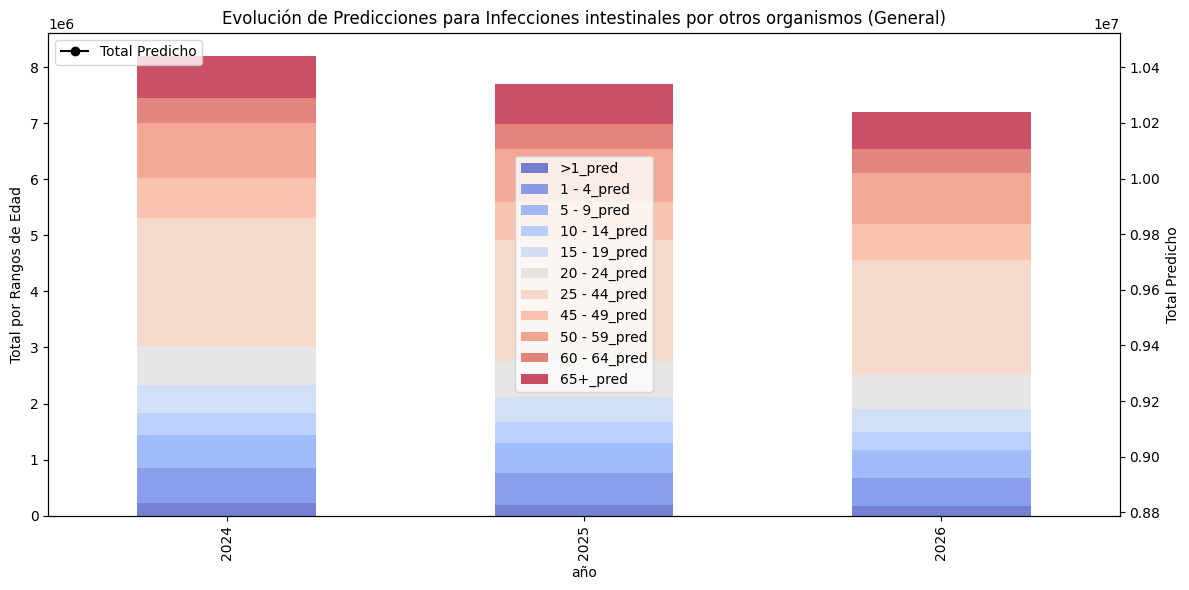

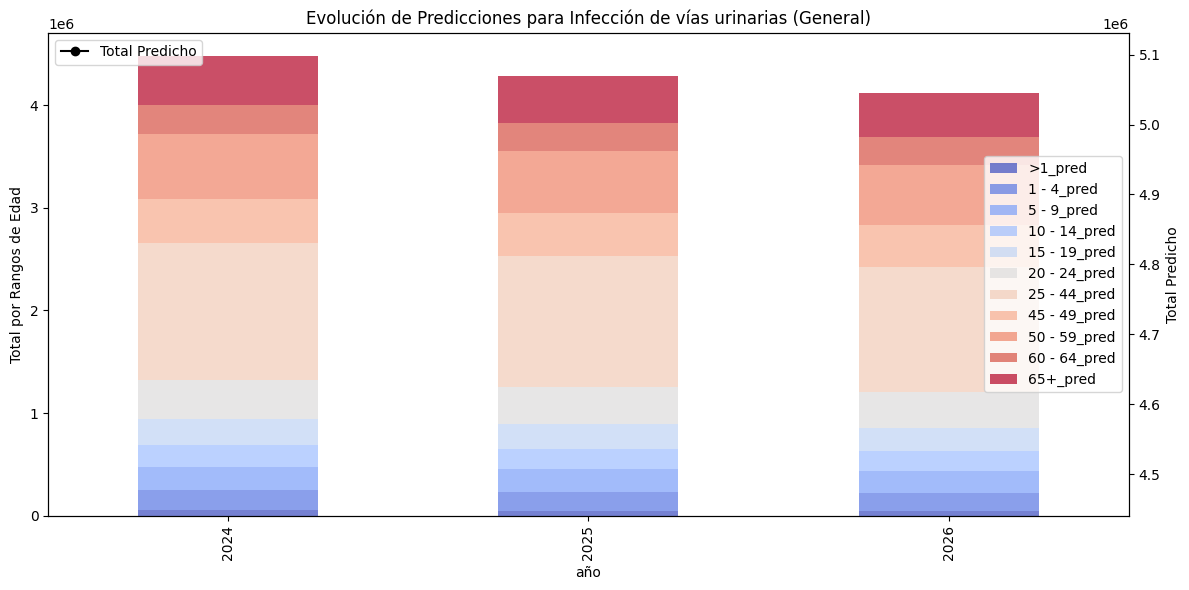

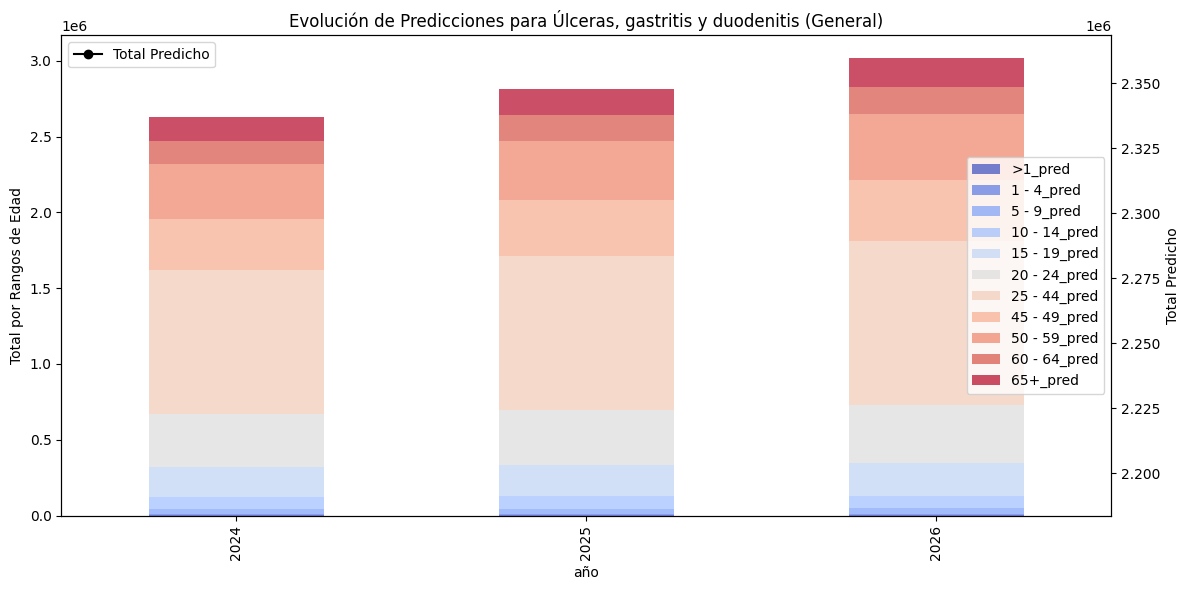

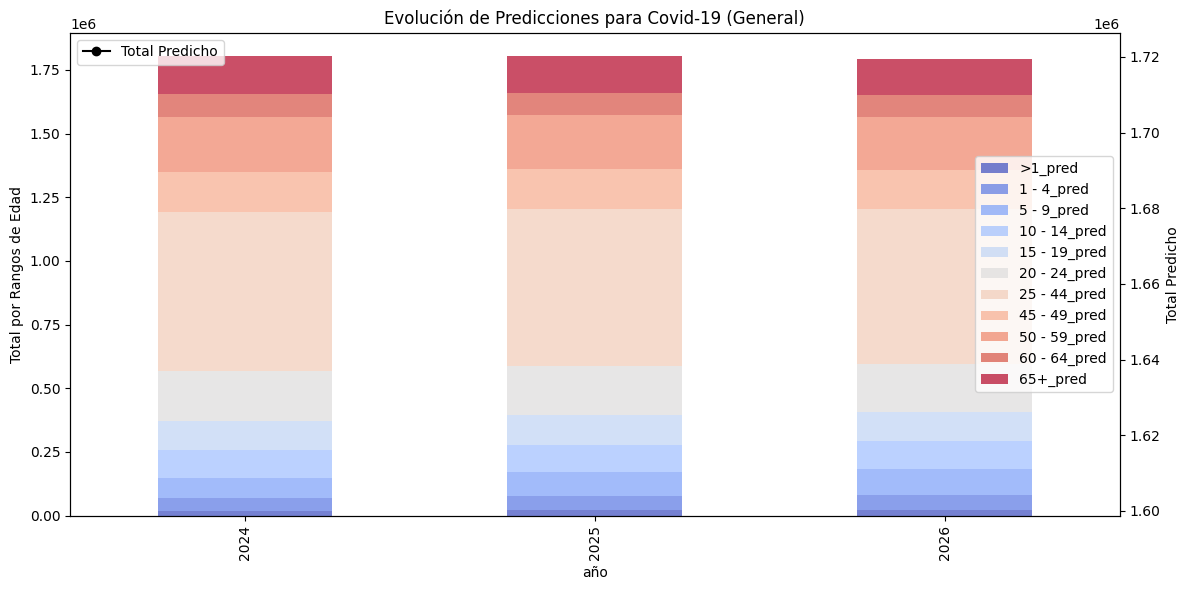

In [495]:
# Función para obtener las 5 enfermedades más comunes
def obtener_top(df, genero=None, top_n=5):
    if genero:
        df = df[df['tipo'] == genero]
    return (
        df.groupby('padecimiento')['Total_pred']
        .sum()
        .nlargest(top_n)
        .index
    )

# 1. Identificar las 5 enfermedades más comunes para cada categoría
top_masculino = obtener_top(predicciones_futuras, genero='Masculino')
top_femenino = obtener_top(predicciones_futuras, genero='Femenino')
top_general = obtener_top(predicciones_futuras,genero='General')

# 2. Crear un conjunto combinado de enfermedades
top_padecimientos = set(top_masculino).union(top_femenino).union(top_general)
df_top = predicciones_futuras[predicciones_futuras['padecimiento'].isin(top_padecimientos)]

# 3. Crear gráficos para cada categoría (masculino, femenino, general)
categorias = {
    'Masculino': top_masculino,
    'Femenino': top_femenino,
    'General': top_general
}

for categoria, padecimientos in categorias.items():
    for padecimiento in padecimientos:
        df_padecimiento = df_top[
            (df_top['padecimiento'] == padecimiento) & 
            ((df_top['tipo'] == categoria) if categoria != 'General' else True)
        ]
        
        # Crear gráfico combinado
        fig, ax1 = plt.subplots(figsize=(12, 6))
        
        # Barras: Distribución por rangos de edad
        distribucion_edades = df_padecimiento.groupby('año')[columnas_rangos_pred].sum()
        distribucion_edades.plot(kind='bar', stacked=True, ax=ax1, colormap='coolwarm', alpha=0.7)
        ax1.set_ylabel('Total por Rangos de Edad')
        ax1.set_title(f'Evolución de Predicciones para {padecimiento.capitalize()} ({categoria})')
        
        # Línea: Total predicho
        ax2 = ax1.twinx()
        df_padecimiento.groupby('año')['Total_pred'].sum().plot(
            kind='line', ax=ax2, color='black', marker='o', label='Total Predicho'
        )
        ax2.set_ylabel('Total Predicho')
        ax2.legend(loc='upper left')
        
        plt.tight_layout()
        plt.show()